In [1]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

import pennylane as qml

C:\Users\realc\OneDrive\Documents\GSOC


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [34]:
QG_channel = 1
filename = f"data/QG{QG_channel}_64x64_1k"
# filename = f"data/QG{QG_channel}_16x16_1k"
data_X = np.array(h5py.File(filename, "r")['X'])
print(data_X.shape)

(1000, 64, 64)


In [35]:
flat_data = data_X.flatten()
sorted_data = np.sort(flat_data)
sorted_set = set(sorted_data)

print("Minimum value in data_X:", sorted_data[0])
print("Second smallest value in data_X:", sorted_set)
print("Maximum value in data_X:", sorted_data[-1])


Minimum value in data_X: 0.0
Second smallest value in data_X: {0.0, 0.0015456415, 0.0015626535, 0.0015504237, 0.0015545416, 0.0015769352, 0.0015890349, 0.0016154019, 0.0016172626, 0.0016341826, 0.001654322, 0.001664813, 0.0016694877, 0.0016708692, 0.0016827168, 0.0016974728, 0.010881294, 0.016389716, 0.024553169, 0.022378791, 0.009471763, 0.020427573, 0.031259406, 3.5391977, 4.9295883, 0.0045946725, 0.004621852, 0.005061019, 0.005068172, 0.0052961, 0.005451549, 0.0069407113, 0.016218044, 0.021680098, 0.0042050965, 0.0032785279, 0.0031029778, 0.00354739, 0.008235653, 0.008262208, 0.0091472175, 0.009357026, 0.017703583, 0.012898972, 0.013036301, 0.021953156, 0.026622346, 0.020670056, 0.0027109385, 0.0028328896, 0.0029873848, 0.003029108, 0.0067598224, 0.016678035, 0.009039164, 0.013561547, 0.013958275, 0.04599076, 0.01023998, 0.011601827, 0.009044073, 0.09023829, 0.15438387, 0.020035975, 0.020423166, 0.0027840063, 0.011666529, 0.012358896, 0.015151255, 0.03188061, 0.034423105, 0.03588985

In [36]:
threshold = 0

# Count elements that are zero
num_zeros = np.sum(np.abs(data_X) == threshold)

total_elements = data_X.size

# Compute sparsity measure
sparsity = num_zeros / total_elements
print(f"Sparsity measure: {sparsity:.4f}")

Sparsity measure: 0.9943


In [56]:
import pennylane as qml
import numpy as np
from itertools import combinations

def pennylane_sparse_IQP_embedding(data, threshold=0, neighbor_limit=None, alpha=1.0, beta=1.0):
    """
    Sparse IQP embedding using PennyLane simulation.
    
    Args:
        data (np.ndarray): Input array of shape (num_samples, H, W)
        threshold (float): Values below this are considered zero (sparsity)
        neighbor_limit (int or None): Max number of pairwise neighbors per active pixel
        alpha (float): Scaling factor for single-qubit phases
        beta (float): Scaling factor for two-qubit (pairwise) phases
    
    Returns:
        embeddings (list of np.ndarray): Expectation values of PauliZ on all qubits
    """
    num_samples, H, W = data.shape
    D = H * W
    n_qubits = int(np.ceil(np.log2(D)))  # number of qubits
    embeddings = []

    dev = qml.device("default.qubit", wires=n_qubits)
    
    for i in range(num_samples):
        x = data[i].flatten()
        active_idx = np.where(np.abs(x) > threshold)[0]
        s = len(active_idx)

        # Define pairwise indices
        if neighbor_limit is None or neighbor_limit >= s:
            pair_idx = list(combinations(active_idx, 2))
        else:
            pair_idx = []
            for j in active_idx:
                neighbors = [k for k in active_idx if k != j][:neighbor_limit]
                pair_idx.extend([(j, k) for k in neighbors])

        @qml.qnode(dev)
        def circuit():
            # Step 1: Hadamards
            for q in range(n_qubits):
                qml.Hadamard(wires=q)
            
            # Step 2: Single-qubit rotations
            for j in active_idx:
                if j < n_qubits:
                    qml.RZ(alpha * x[j], wires=j)
            
            # Step 3: Two-qubit diagonal rotations
            for j, k in pair_idx:
                if j < n_qubits and k < n_qubits:
                    qml.CNOT(wires=[j,k])
                    qml.RZ(2 * beta * x[j] * x[k], wires=k)
                    qml.CNOT(wires=[j,k])
            
            # Step 4: Hadamards again
            for q in range(n_qubits):
                qml.Hadamard(wires=q)
            
            # Return expectation values of Z on all qubits
            return [qml.expval(qml.PauliZ(wires=q)) for q in range(n_qubits)]
        
        embeddings.append(np.array(circuit()))
    
    return embeddings

# embeddings = pennylane_sparse_IQP_embedding(data_X, threshold=0, neighbor_limit=4)
embeddings = pennylane_sparse_IQP_embedding(data_X, alpha=50.0, beta=5.0)

print("Number of embeddings:", len(embeddings))

print("Example embedding vector:", embeddings[0])


Number of embeddings: 1000
Example embedding vector: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [57]:
print(embeddings)

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1.,

In [37]:
def sparse_IQP(data, threshold=1e-8):
    """
    Sparse IQP implementation for 2D arrays.
    
    Args:
        data (np.ndarray): Input array of shape (num_samples, H, W)
        threshold (float): Values below this are treated as zero (sparsity)
    
    Returns:
        result (np.ndarray): IQP-transformed data
    """
    num_samples, H, W = data.shape
    result = np.zeros_like(data)
    
    for i in range(num_samples):
        sample = data[i]
        # Apply sparsity mask
        mask = np.abs(sample) > threshold
        sparse_sample = sample * mask  # Zero out near-zero elements
        
        # IQP operation: sum of pairwise products (example)
        # Here we do it efficiently only over non-zero elements
        non_zero_indices = np.argwhere(mask)
        q_sum = 0
        for idx1 in range(len(non_zero_indices)):
            for idx2 in range(idx1+1, len(non_zero_indices)):
                x1 = tuple(non_zero_indices[idx1])
                x2 = tuple(non_zero_indices[idx2])
                q_sum += sparse_sample[x1] * sparse_sample[x2]
        
        result[i] = sparse_sample  # or store q_sum if scalar result needed
    
    return result

# Run sparse IQP
iqp_result = sparse_IQP(data_X, threshold=1e-8)
print("Sparse IQP applied. Result shape:", iqp_result.shape)

Sparse IQP applied. Result shape: (1000, 64, 64)


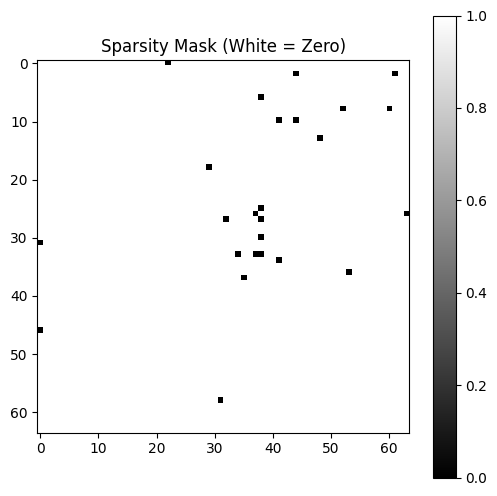

In [39]:
sample = data_X[0]
threshold = 1e-8
sparsity_mask = np.abs(sample) < threshold

plt.figure(figsize=(6,6))
plt.imshow(sparsity_mask, cmap='gray')
plt.title("Sparsity Mask (White = Zero)")
plt.colorbar()
plt.show()

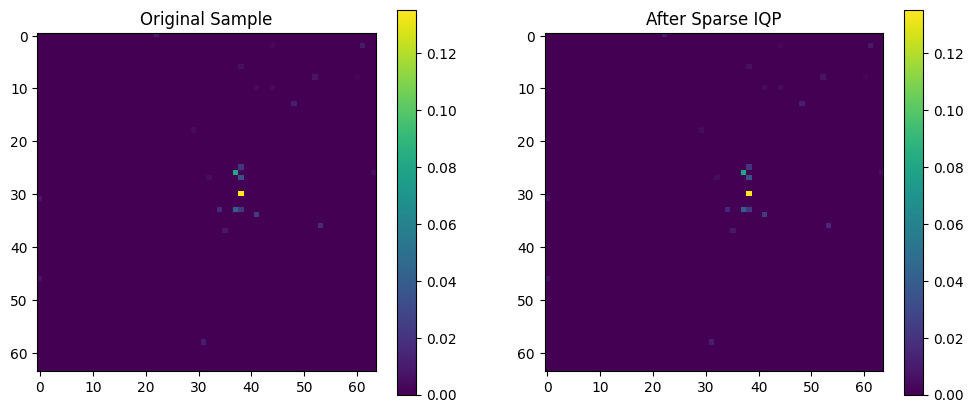

In [42]:
iqp_sample = iqp_result[0]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(sample, cmap='viridis')
plt.title("Original Sample")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(iqp_sample, cmap='viridis')
plt.title("After Sparse IQP")
plt.colorbar()

plt.show()


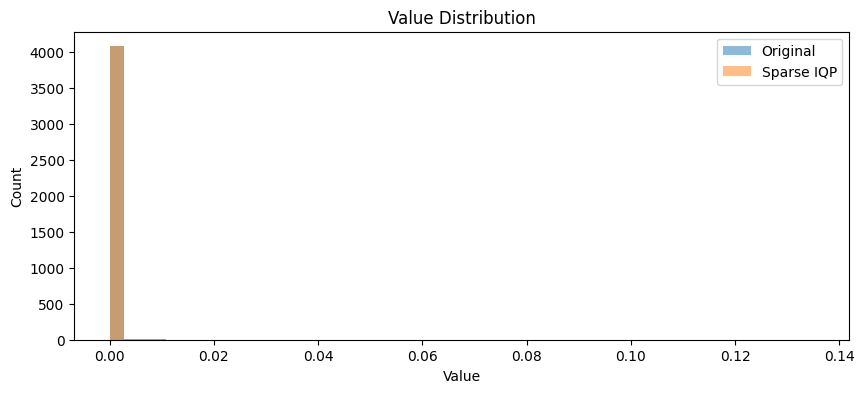

In [43]:
plt.figure(figsize=(10,4))
plt.hist(sample.flatten(), bins=50, alpha=0.5, label='Original')
plt.hist(iqp_sample.flatten(), bins=50, alpha=0.5, label='Sparse IQP')
plt.title("Value Distribution")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()
plt.show()
